# Quality of the data in general


Here I plot graphs of peak I and FWHM variations for different cycles.
All data were reduced using the SPHERE DC without normalisation (which is useful for this case and will be performed later)
Apperture polarimetry

Works for all ZIMPOL data reduced with individual cycles
Specifically for the AR Pup


__This script is in use for paper Andrych et al 2024b__

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp
from matplotlib.ticker import ScalarFormatter,FormatStrFormatter,EngFormatter
import re


In [2]:
DI = None
PDI = None

In [3]:
def load_and_make_polar(dirdat,camera):
    dir = dirdat
    qfile = '*sci'+camera+'.fits'
    print(qfile)
    files = os.listdir(dir)
    print(files)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            print(hdulq)
            iq = hdulq[0].data[0]
            q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            u = hdulq[0].data[3]
            n=q.shape[0]
             #Creating grid         
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)
            R = np.sqrt(Xr**2 + Yr**2)
            phi = np.arctan(Yr/Xr)
            i=(iq+iu)/2
            q_phi=q*np.cos(2*phi)+u*np.sin(2*phi)
            q_phi = (q_phi > 0)*q_phi +  (q_phi <=0 )*1e-10
            u_phi=q*np.sin(2*phi)+u*np.cos(2*phi)
            pi=np.sqrt(q*q+u*u)
            aolp=0.5*np.arctan2(u, q)+np.pi/2
    return iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi

def load_and_make_polar_umon(dirdat,cycle,camera):
    #q
    dir = dirdat+'q_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            q = hdulq[0].data
            n=q.shape[0]
    #u
    dir = dirdat+'u_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            u = hdulq[0].data
    #qphi
    dir = dirdat+'qphi_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            qphi = hdulq[0].data
            
    #uphi
    dir = dirdat+'uphi_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            uphi = hdulq[0].data
            
            
            
    #iq,iu
    dir = dirdat+'sci/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            iu = hdulq[0].data[2]
            
            
            
             #Creating grid         
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)
            R = np.sqrt(Xr**2 + Yr**2)
            phi = np.arctan(Yr/Xr)
            
            i=(iq+iu)/2
            
            qphi = (qphi > 0)*qphi +  (qphi <=0 )*1e-10
            pi=np.sqrt(q*q+u*u)
            aolp=0.5*np.arctan2(u, q)+np.pi/2
            
    return iq,q,iu,u,i,qphi,uphi,pi,aolp,R,phi

def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   

def maskcrit(aolp,R):
    phi = (aolp-90)  
    n=aolp.shape[0]
    critarray=np.zeros_like(phi)
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]>180:
                phi[ix,iy]=phi[ix,iy]-180
            
    for ix in range (2,n-2):
        for iy in range(2,n-2):
            if R[ix,iy]>=1:            
                datapix=[]
                for (iix,iiy) in [(ix,iy),(ix-1,iy),(ix+1,iy),(ix,iy-1),(ix,iy+1)]: 
                    if R[iix,iiy]>=1:
                        datapix.append(abs(phi[iix,iiy]))
                            
                
                crit=np.std(datapix)               
                critarray[ix,iy]=crit
                
    for ix in range (0,n-1):
        for iy in range(0,n-1):
            if critarray[ix,iy]==0:
                critarray[ix,iy]=np.max(critarray)
    medianstd=np.nanmedian(critarray)
    
    mask=(critarray<=medianstd)#*R([ix,iy]>=1)
    return mask
        
def plot_AoLP(ps,R,Q,U,I,Q_PHI,PI,AOLP,title,save):
    # First, we plot the background image
    fig = plt.figure(figsize=(8,8))
    i_plot = fig.add_subplot(111)
    n = I.shape[0]
    d = n * ps / 2

    im1=i_plot.imshow(np.arcsinh(Q_PHI), origin='lower',extent=(-d, d, d, -d))

    fig.colorbar(im1, orientation='vertical')

    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = i_plot.get_xlim()
    yy0, yy1 = i_plot.get_ylim()

    # binning factor
    factor = [4, 4]

    # re-binned number of points in each axis
    nx_new = PI.shape[1] // factor[0]
    ny_new = PI.shape[0] // factor[1]

    # These are the positions of the quivers
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    PI_bin=PI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    aolp_bin=AOLP.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)

    # polarization angle
    psi=0.5*np.arctan2(U_bin, Q_bin)

    #psi=aolp_bin
    #i_plot.imshow(psi, origin='lower',extent=(-d, d, d, -d))

    # polarization fraction
    frac =Q_phi_bin/I_bin
    #frac=dolp_v[adc:bdc,adc:bdc]
    # mask to show only alighned

    mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=10
    mask=mask2#*mask1
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = frac*np.cos(psi+np.pi/2) # X-vector 
    pixY = frac*np.sin(psi+np.pi/2) # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
    i_plot.quiver(X[mask], Y[mask], pixX[mask], pixY[mask],scale=2, **quiveropts)
    plt.title(title)
    plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    #plt.show()#(dirName+"aolp.png",bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

def find_FWHM (PSF,n,ps,figfolder,title):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])


    plt.plot(xdata, y1, 'o', label='vertical')
    plt.plot(xdata, gaus(xdata,*popt1), '-', label='fit1')
    plt.plot(xdata, y2, 'o', label='horizotal')
    plt.plot(xdata, gaus(xdata,*popt2), '-', label='fit2')
    plt.legend()
    plt.title(title)
    plt.savefig(figfolder+title+'.png',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2*ps

    return fwhm

def ap_fixed_in(rad,R,q,u,PSF):            
    mask = (R <= rad)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100
    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def ap(radin,radout,R,q,u,PSF):
    mask = (R <= radout) * (R >= radin)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100

    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent


# direct imaging only

def load_and_make_unpolar(dirdat,camera):
    dir = dirdat
    qfile = '*_sci'+camera+'.fits'
    print(qfile)
    files = os.listdir(dir)
    print(files)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            print(hdulq)
            i = hdulq[0].data[0]
            n=i.shape[0]
             #Creating grid
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)
            R = np.sqrt(Xr**2 + Yr**2)
            phi = np.arctan(Yr/Xr)
    return i,R, phi

def unp_ap_fixed_in(rad,R,PSF):
    mask = (R <= rad)
    psf_sum = np.sum(PSF[mask])
    return psf_sum

def unp_ap(radin,radout,R,PSF):
    mask = (R <= radout) * (R >= radin)
    psf_sum = np.sum(PSF[mask])
    return psf_sum


In [4]:
#star='IRAS08544-4431'  'HD83878'   'HD75885' 'AR_Pup'
PDI = None
DI = None
#stars=['HR4049_20190108','HR4049_20190107','HR4226','HD71253','HD94680','HD96314','HD98025','V709_Car','HD75885', 'AR_Pup_dc_notnorm','UMon']
# stars=['02.SCI_AR_Pup']#,'REF_HD75885']
stars=['01.SCI_AR_Pup']
starnames = {'01.SCI_AR_Pup':'AR_Pup','UMon':'UMon','02.SCI_AR_Pup':'AR_Pup','UMon_Katya':'UMon_Katya','REF_HD75885':'HD75885','REF_HD74128':'HD74128'}
fittypes=['1', '2']

band=['V','I']
ps=3.6
# ps=6.8

# DI = True

In [32]:
# you changed around the load_and_make_polar function to have _sci instead of just sci for 02.SCIARP

## Apperture polarimetry and other characteristics for each frame in the sample

### In the following cell: without correction of the intrinsic polarisation

max DoLP in the region R>=1.5 and R<500/ps  (500 mas in radius)

HERE IS NOT THE FINAL VERSION THAT WENT TO THE PAPER. FOR THE PAPER IN "Paper2_IRAS08_with_ref_correction.ipynb" FOR THE SELECTED FRAMES

In [5]:
fittypes

['1', '2']

In [34]:
if PDI == True:
    for star in stars:
        # create folders for data and image outputs
        figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/'
        createfolder(figfolder)
        figfolder0=figfolder+ 'Quality_indiv_cycles/'
        createfolder(figfolder)
        figfolder=figfolder+ 'no_unres_correction/'
        createfolder(figfolder)

        if star=='02.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/'  #For AR_Pup
            input_filename =dirdat+'process_list.csv'
        elif star=='01.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/'  #For AR_Pup
            input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
        else:
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/'+starnames[star] +'/' #For AR_Pup
            input_filename =dirdat+'process_list.csv'



        table = pd.read_csv(input_filename)
        table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

        processes=table['id']

        print(table['id'])

        reference={process:ref for process,ref in zip(table['id'], table['reference'])}


        # print(reference)

        for fittype in fittypes:
            print(fittype)
            # print('Processing '+starnames[star])
            output_filename = figfolder0+star+'_'+band[int(fittype)-1]+'_Original_AP_per_cycle.txt'
            output_filename = figfolder0+star+'_'+band[int(fittype)-1]+'_Original_AP_per_cycle.txt'
            with open(output_filename, 'w') as file_print:
                line="{:<30} {:<5} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}\n".format(
                    'reference','cycle',"max_DoLP[%]", "max_Q_phi", "max_PI", "sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]",
                    'FWHM','CNT60[%]','Peak_i(Strehl)','Peak_PI','peak_Q_Phi',
                    '0-3_PSF', '0-3_Q', '0-3_U', '0-3_Q/I[%]', '0-3_U/I[%]',
                    '0-5_PSF', '0-5_Q', '0-5_U', '0-5_Q/I[%]', '0-5_U/I[%]',
                    '0-10_PSF', '0-10_Q', '0-10_U', '0-10_Q/I[%]', '0-10_U/I[%]',
                    '0-50_PSF', '0-50_Q', '0-50_U', '0-50_Q/I[%]', '0-50_U/I[%]',
                    '0-100_PSF', '0-100_Q', '0-100_U', '0-100_Q/I[%]', '0-100_U/I[%]',
                    '1-3_PSF', '1-3_Q', '1-3_U', '1-3_Q/I[%]', '1-3_U/I[%]',
                    '3-5_PSF', '3-5_Q', '3-5_U', '3-5_Q/I[%]', '3-5_U/I[%]',
                    '3-30_PSF', '3-30_Q', '3-30_U', '3-30_Q/I[%]', '3-30_U/I[%]',
                    '5-30_PSF', '5-30_Q', '5-30_U', '5-30_Q/I[%]', '5-30_U/I[%]')

                file_print.write(line)

                for process in processes:
                    print(process)
                    print(reference)

                    print("We are are starting this ", process)

                    print(reference[process])

                    if star=='UMon':
                        dirName=dirdat
                        iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar_umon(dirName,process,fittype)
                    else:
                        print("other")
                        dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
                        iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)

                    print(dirName)
                    n=q.shape[0]
                    if starnames[star]=='AR_Pup':
                        lim=150
                    else:
                        lim=50

                    filename={0:'PI',1:'Q_phi', 2:"U_phi",3:'Q',4:'U',5:'I'}

                    print("step 1")

                    frac =np.max(np.divide(q_phi,i,where=i!=0)*(R<=500/ps)*(R>=1.5))*100
                    mask=(R<=500/ps)
                    q_sum=np.sum(q[mask])
                    # print(q[mask])
                    qphi_sum=np.sum(q_phi[mask])
                    I_sum=np.sum(i[mask])
                    pi_sum=np.sum(pi[mask])

                    fwhm=find_FWHM (i,n,ps,figfolder,band[int(fittype)-1]+'_gauss_'+reference[process])
                    #normalise the image to the 10e6, might be useful for further comparison ZIMPOL with IRDIS but not really now.
                    mask=(R<=1500/ps)
                    middle=int(n/2)
                    ctn6=i*np.sum(i[mask])/10e6
                    cnt60=np.max(ctn6[middle-1:middle+1,middle-1:middle+1])/10e6*100

                    #calculating what is the ratio of peak brightness to the total. For I it refers to the observational conditions and is a proxy of strehl
                    normalisation=np.sum(i[mask])
                    peak_i=np.max(i*(R<200))/normalisation
                    peak_pi=np.max(pi*(R<200))/normalisation
                    peak_q_phi=np.max(q_phi*(R<200))/normalisation #migh be less informative than PI because of unresolved signal in the center

                     #extracting cyclenumber from reference
                    if star=='HD83878'  or star=='UMon_Katya' or star== 'HD75885' or star== 'HD71253' or star=='HD94680' or star=='HD96314' or star=='HD98025' or star=='HR4226':
                        cycle_number=reference[process].split('_')[1][:-1]
                    elif star=='02.SCI_AR_Pup':
                        cycle_number=reference[process][5:7]
                    else:
                        cycle_number=reference[process].split('_')[2][:-1]

                    psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3=ap_fixed_in(3,R,q,u,i)
                    psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5=ap_fixed_in(5,R,q,u,i)
                    psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10=ap_fixed_in(10,R,q,u,i)
                    psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50=ap_fixed_in(50,R,q,u,i)
                    psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100=ap_fixed_in(100,R,q,u,i)

                    psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3=ap(1,3,R,q,u,i)
                    psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5=ap(3,5,R,q,u,i)
                    psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30=ap(5,30,R,q,u,i)
                    psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30=ap(3,30,R,q,u,i)


                    line = "{:<30} {:<5} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.6f} {:<15.8f} {:<15.8f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} \n".format(  \
                            reference[process],cycle_number, \
                            frac, np.max(q_phi), np.max(pi), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100, \
                            fwhm,cnt60,peak_i,peak_pi,peak_q_phi, \
                            psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3, \
                            psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5, \
                            psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10, \
                            psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50, \
                            psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100, \
                            psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3, \
                            psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5, \
                            psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30,  \
                            psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30)
                    file_print.write(line)
                    #print(line)

                    for fileindex,image1 in enumerate([pi,q_phi, u_phi,q,u,i]):
                        image_an = image1*(R<250)
                        image=np.arcsinh(image_an)
                        fig, ax = plt.subplots()
                        f.plottingroutinemas(image,lim,ps,n,star,ax)
                        f.scale_mas(star,ax)

                        plt.title(reference[process]+', '+filename[fileindex]+', '+band[int(fittype)-1])
                        plt.savefig(figfolder+band[int(fittype)-1]+'_'+filename[fileindex]+'_'+reference[process]+'.png',bbox_inches='tight', pad_inches=0.1)
                        #plt.show()
                        plt.close()

In [52]:
if DI == True:
     for star in stars:
        # create folders for data and image outputs
        figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/'
        createfolder(figfolder)
        figfolder0=figfolder+ 'Quality_indiv_cycles/'
        createfolder(figfolder0)
        figfolder=figfolder+ 'no_unres_correction/'
        createfolder(figfolder)

        if star=='02.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/'  #For AR_Pup
            input_filename =dirdat+'process_list.csv'
        elif star=='01.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/'  #For AR_Pup
            input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
        else:
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/'+starnames[star] +'/' #For AR_Pup
            input_filename =dirdat+'process_list.csv'



        table = pd.read_csv(input_filename)
        table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

        processes=table['id']

        # print(table['id'])

        reference={process:ref for process,ref in zip(table['id'], table['reference'])}


        # print(reference)

        for fittype in fittypes:
            print("We are working on camera ", fittype)
            current_band = band[int(fittype) - 1]
            print("Current band:", current_band)
            # print('Processing '+starnames[star])
            # output_filename = figfolder0+star+'_'+band[int(fittype)-1]+'_Original_AP_per_cycle.txt'
            output_filename = figfolder0+star+'_'+band[int(fittype)-1]+'_Original_AP_per_cycle.txt'
            with open(output_filename, 'w') as file_print:
                line="{:<30} {:<5} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}\n".format(
                    'reference','frame',
                    'FWHM','CNT60[%]','Peak_i(Strehl)',
                    '0-3_PSF',
                    '0-5_PSF',
                    '0-10_PSF',
                    '0-50_PSF',
                    '0-100_PSF',
                    '1-3_PSF',
                    '3-5_PSF',
                    '3-30_PSF',
                    '5-30_PSF', )

                file_print.write(line)

                for process in processes:
                    # print(process)
                    # print(reference)
                    #
                    # print("We are are starting this ", process)
                    #
                    # print(reference[process])

                    if star=='UMon':
                        dirName=dirdat
                        iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar_umon(dirName,process,fittype)
                    else:
                        # print("other")
                        dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
                        i,R,phi= load_and_make_unpolar(dirName,fittype)

                    # print(dirName)
                    n=i.shape[0]
                    if starnames[star]=='AR_Pup':
                        lim=150
                    else:
                        lim=50

                    filename={0:'I'}

                    # print("step 1")

                    mask=(R<=500/ps)
                    I_sum=np.sum(i[mask])

                    fwhm=find_FWHM (i,n,ps,figfolder,band[int(fittype)-1]+'_gauss_'+reference[process])
                    # normalise the image to the 10e6, might be useful for further comparison ZIMPOL with IRDIS but not really now.
                    mask=(R<=1500/ps)
                    middle=int(n/2)
                    ctn6=i*np.sum(i[mask])/10e6
                    cnt60=np.max(ctn6[middle-1:middle+1,middle-1:middle+1])/10e6*100

                    #calculating what is the ratio of peak brightness to the total. For I it refers to the observational conditions and is a proxy of strehl
                    normalisation=np.sum(i[mask])
                    peak_i=np.max(i*(R<200))/normalisation


                     #extracting cyclenumber from reference
                    if star=='HD83878'  or star=='UMon_Katya' or star== 'HD75885' or star== 'HD71253' or star=='HD94680' or star=='HD96314' or star=='HD98025' or star=='HR4226':
                        cycle_number=reference[process].split('_')[1][:-1]
                    elif star=='02.SCI_AR_Pup' or star=='REF_HD74128':
                        cycle_number=reference[process][5:7]
                        match = re.search(r'frame(\d+)_', reference[process])
                        if match:
                            cycle_number = match.group(1)
                    else:
                        cycle_number=reference[process].split('_')[2][:-1]

                    psf_sum3=unp_ap_fixed_in(3,R,i)
                    psf_sum5=unp_ap_fixed_in(5,R,i)
                    psf_sum10=unp_ap_fixed_in(10,R,i)
                    psf_sum50=unp_ap_fixed_in(50,R,i)
                    psf_sum100=unp_ap_fixed_in(100,R,i)

                    psf_sum1_3=unp_ap(1,3,R,i)
                    psf_sum3_5=unp_ap(3,5,R,i)
                    psf_sum5_30=unp_ap(5,30,R,i)
                    psf_sum3_30=unp_ap(3,30,R,i)


                    line = "{:<30} {:<5} {:<15.3f} {:<15.5f} {:<15.8f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.6f} {:<15.8f} {:<15.8f} {:<15.6f}\n".format(
                            reference[process],cycle_number,
                            # frac, np.max(q_phi), np.max(pi), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100, \
                            fwhm,cnt60,peak_i,  #,peak_pi,peak_q_phi, \
                            psf_sum3,
                            psf_sum5,
                            psf_sum10,
                            psf_sum50,
                            psf_sum100,
                            psf_sum1_3,
                            psf_sum3_5,
                            psf_sum3_30,
                            psf_sum5_30,)
                    file_print.write(line)
                    #print(line)

                    for fileindex,image1 in enumerate([i]):
                        image_an = image1*(R<250)
                        image=np.arcsinh(image_an)
                        fig, ax = plt.subplots()
                        f.plottingroutinemas(image,lim,ps,n,star,ax)
                        f.scale_mas(star,ax)

                        plt.title(reference[process]+', '+filename[fileindex]+', '+band[int(fittype)-1])
                        plt.savefig(figfolder+band[int(fittype)-1]+'_'+filename[fileindex]+'_'+reference[process]+'.png',bbox_inches='tight', pad_inches=0.1)
                        #plt.show()
                        plt.close()




We are working on camera  1
Current band: V
*_sci1.fits
['frame01_sci1.fits', 'frame01_sci2.fits']
*_sci1.fits
['frame02_sci2.fits', 'frame02_sci1.fits']
*_sci1.fits
['frame03_sci2.fits', 'frame03_sci1.fits']
*_sci1.fits
['frame04_sci2.fits', 'frame04_sci1.fits']
*_sci1.fits
['frame05_sci2.fits', 'frame05_sci1.fits']
*_sci1.fits
['frame06_sci1.fits', 'frame06_sci2.fits']
*_sci1.fits
['frame07_sci1.fits', 'frame07_sci2.fits']
*_sci1.fits
['frame08_sci2.fits', 'frame08_sci1.fits']
*_sci1.fits
['frame09_sci2.fits', 'frame09_sci1.fits']
*_sci1.fits
['frame10_sci2.fits', 'frame10_sci1.fits']
*_sci1.fits
['frame11_sci2.fits', 'frame11_sci1.fits']
*_sci1.fits
['frame12_sci1.fits', 'frame12_sci2.fits']
*_sci1.fits
['frame13_sci1.fits', 'frame13_sci2.fits']
*_sci1.fits
['frame14_sci1.fits', 'frame14_sci2.fits']
*_sci1.fits
['frame15_sci1.fits', 'frame15_sci2.fits']
*_sci1.fits
['frame16_sci2.fits', 'frame16_sci1.fits']
*_sci1.fits
['frame17_sci2.fits', 'frame17_sci1.fits']
*_sci1.fits
['fram

In [36]:
processes

0     polarimetric_frame_01
1     polarimetric_frame_02
2     polarimetric_frame_03
3     polarimetric_frame_04
4     polarimetric_frame_05
              ...          
58    polarimetric_frame_59
59    polarimetric_frame_60
60    polarimetric_frame_61
61    polarimetric_frame_62
62    polarimetric_frame_63
Name: id, Length: 63, dtype: object

### In the following cell all the same but with correction of the intrinsic polarisation

HERE IS NOT THE FINAL VERSION THAT WENT TO THE PAPER. FOR THE PAPER IN "Paper2_IRAS08_with_ref_correction.ipynb" FOR THE SELECTED FRAMES

In [37]:
annuli=[3,5]#,10,200,270]
annuli_name={3:'0-3',5:'0-5',10:'0-10',200:'30-200',270:'100-200'}
#stars=['IRAS08544-4431','AR_Pup', 'IRAS08544-4431_dc_notnorm','AR_Pup_dc_notnorm']

#for star in stars:

if PDI == True:

    for star in stars:
        figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'

        if star=='01.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
            input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
        elif star=='02.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
            input_filename =dirdat+'process_list.csv'


        elif star=='IRAS08544-4431':

            dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
            input_filename =dirdat+'IRAS08process_list.csv'
        elif star=='IRAS08544-4431_dc_notnorm':
            dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
            input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'

        elif star=='UMon':
            dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/UMon_data/HansMartin/'
            input_filename =dirdat+'UMon_cycle_list.csv'

        else:
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/'+starnames[star]+'/'
            input_filename =dirdat+'process_list.csv'

        table = pd.read_csv(input_filename)
        table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

        processes=table['id']

        reference={process:ref for process,ref in zip(table['id'], table['reference'])}



        print(reference)
        for annulus in annuli:
            print(annuli_name[annulus])
            figfolder=figfolder0+ annuli_name[annulus]+'_unres_correction/'
            createfolder(figfolder)
            #figfolder=dirdat+'images_'+annuli_name[annulus]+'/'
            for fittype in fittypes:
                output_filename = figfolder0+star+'_'+annuli_name[annulus]+'_'+band[int(fittype)-1]+'_AP_per_cycle.txt'

                with open(output_filename, 'w') as file_print:
                    line="{:<30} {:<5} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}\n".format(
                            'reference','cycle',"max_DoLP[%]", "max_Q_phi", "max_PI", "sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]",
                            'FWHM','CNT60[%]','Peak_i(Strehl)','Peak_PI','peak_Q_Phi',
                            '0-3_PSF', '0-3_Q', '0-3_U', '0-3_Q/I[%]', '0-3_U/I[%]',
                            '0-5_PSF', '0-5_Q', '0-5_U', '0-5_Q/I[%]', '0-5_U/I[%]',
                            '0-10_PSF', '0-10_Q', '0-10_U', '0-10_Q/I[%]', '0-10_U/I[%]',
                            '0-50_PSF', '0-50_Q', '0-50_U', '0-50_Q/I[%]', '0-50_U/I[%]',
                            '0-100_PSF', '0-100_Q', '0-100_U', '0-100_Q/I[%]', '0-100_U/I[%]',
                            '1-3_PSF', '1-3_Q', '1-3_U', '1-3_Q/I[%]', '1-3_U/I[%]',
                            '3-5_PSF', '3-5_Q', '3-5_U', '3-5_Q/I[%]', '3-5_U/I[%]',
                            '3-30_PSF', '3-30_Q', '3-30_U', '3-30_Q/I[%]', '3-30_U/I[%]',
                            '5-30_PSF', '5-30_Q', '5-30_U', '5-30_Q/I[%]', '5-30_U/I[%]')

                    file_print.write(line)
                    for process in processes:

                        print(reference[process])

                        if star=='UMon':
                            dirName=dirdat
                            iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar_umon(dirName,process,fittype)
                        else:
                            dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
                            iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)

                        n=q.shape[0]
                         #Creating grid
                        if star=='AR_Pup':
                            lim=150
                        else:
                            lim=150
                        #Correction for the unresolved polarisation
                        correction_radius=annulus
                        if annulus==200:
                            mask=(R<=correction_radius)*(R>=30)
                        if annulus==270:
                            mask=(R<=200)*(R>=100)
                        else:
                            mask=(R<=correction_radius)

                        q_over_i=np.divide(q,i,where=i!=0)


                        cq=np.median(q_over_i[mask]) #for median normal as in IRDIS
                        u_over_i=np.divide(u,i,where=i!=0)
                        cu=np.median(u_over_i[mask]) #for median normal as in IRDIS
                        q_corr=q-cq*iq
                        u_corr=u-cu*iu
                        q_phi_corr=q_corr*np.cos(2*phi)+u_corr*np.sin(2*phi)
                        q_phi_corr = (q_phi_corr> 0)*q_phi_corr +  (q_phi_corr <=0 )*1e-10
                        u_phi_corr=q_corr*np.sin(2*phi)+u_corr*np.cos(2*phi)
                        pi_corr=np.sqrt(q_corr*q_corr+u_corr*u_corr)
                        aolp_corr=0.5*np.arctan2(u_corr, q_corr)+np.pi/2
                        angleofpol=np.rad2deg(0.5*np.arctan2(cu, cq))
                        if angleofpol<0: angleofpol+=180

                        frac =np.max(np.divide(q_phi_corr,i,where=i!=0)*(R<=500/ps)*(R>1.5))*100
                        mask=(R<=500/ps)
                        q_sum=np.sum(q_corr[mask])
                        qphi_sum=np.sum(q_phi_corr[mask])
                        I_sum=np.sum(i[mask])
                        pi_sum=np.sum(pi_corr[mask])

                        fwhm=find_FWHM (i,n,ps,figfolder,band[int(fittype)-1]+'_gauss_'+reference[process])
                        #normalise the image to the 10e6, might be useful for further comparison ZIMPOL with IRDIS but not really now.
                        mask=(R<=1500/ps)

                        middle=int(n/2)
                        ctn6=i*np.sum(i[mask])/10e6
                        cnt60=np.max(ctn6[middle-1:middle+1,middle-1:middle+1])/10e6*100

                        #calculating what is the ratio of peak brightness to the total in 3'' apperture. For I it refers to the observational conditions and is a proxy of strehl
                        normalisation=np.sum(i[mask])
                        peak_i=np.max(i*(R<500/ps))/normalisation
                        peak_pi=np.max(pi_corr*(R<500/ps))/normalisation
                        peak_q_phi=np.max(q_phi_corr*(R<500/ps))/normalisation #migh be less informative than PI because of unresolved signal in the center

                        #extracting cyclenumber from reference
                        if star=='HD83878' or star=='UMon_Katya' or star== 'HD75885' or star== 'HD71253' or star=='HD94680' or star=='HD96314' or star=='HD98025' or star=='HR4226':
                            cycle_number=reference[process].split('_')[1][:-1]
                        elif star=='02.SCI_AR_Pup' or star=='REF_HD74128':
                            cycle_number=reference[process][5:7]
                        else:
                            cycle_number=reference[process].split('_')[2][:-1]
                        psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3=ap_fixed_in(3,R,q_corr,u_corr,i)
                        psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5=ap_fixed_in(5,R,q_corr,u_corr,i)
                        psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10=ap_fixed_in(10,R,q_corr,u_corr,i)
                        psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50=ap_fixed_in(50,R,q_corr,u_corr,i)
                        psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100=ap_fixed_in(100,R,q_corr,u_corr,i)

                        psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3=ap(1,3,R,q_corr,u_corr,i)
                        psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5=ap(3,5,R,q_corr,u_corr,i)
                        psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30=ap(5,30,R,q_corr,u_corr,i)
                        psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30=ap(3,30,R,q_corr,u_corr,i)



                        line = "{:<30} {:<5} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.6f} {:<15.8f} {:<15.8f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} \n".format(  \
                            reference[process],cycle_number, \
                            frac, np.max(q_phi_corr), np.max(pi_corr), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100, \
                            fwhm,cnt60,peak_i,peak_pi,peak_q_phi, \
                            psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3, \
                            psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5, \
                            psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10, \
                            psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50, \
                            psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100, \
                            psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3, \
                            psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5, \
                            psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30,  \
                            psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30)


                        file_print.write(line)
                        #print(line)

                        #plotting part
                        filename={0:'Q_phi_corr',1:'U_phi_corr',2:'PI_corr'}

                        for fileindex,image1 in enumerate([q_phi_corr,u_phi_corr,pi_corr]):
                            image_an = image1*(R<250)
                            image=np.arcsinh(image_an)
                            fig, ax = plt.subplots()
                            f.plottingroutinemas(image,lim,ps,n,star,ax)
                            f.scale_mas(star,ax)

                            plt.title(reference[process]+', '+filename[fileindex]+', '+annuli_name[annulus]+', '+band[int(fittype)-1])
                            plt.savefig(figfolder+band[int(fittype)-1]+'_'+filename[fileindex]+'_'+reference[process]+'.png',bbox_inches='tight', pad_inches=0.1)
                            #plt.show()
                            plt.close()
                        adc=int(440)
                        bdc=int(n-440)

                        title=reference[process]+', '+'AoLP'+', '+annuli_name[annulus]+', '+band[int(fittype)-1]

                        save=figfolder+band[int(fittype)-1]+'_aolp_'+reference[process]+'.png'
                        plot_AoLP(ps,R[adc:bdc,adc:bdc],q_corr[adc:bdc,adc:bdc],u_corr[adc:bdc,adc:bdc],i[adc:bdc,adc:bdc],q_phi_corr[adc:bdc,adc:bdc],pi_corr[adc:bdc,adc:bdc],aolp_corr[adc:bdc,adc:bdc],title,save)

In [38]:
annuli=[3,5]#,10,200,270]
annuli_name={3:'0-3',5:'0-5',10:'0-10',200:'30-200',270:'100-200'}

if DI == True:

    for star in stars:
        figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'

        if star=='01.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
            input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
        elif star=='02.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
            input_filename =dirdat+'process_list.csv'

        else:
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/'+starnames[star]+'/'
            input_filename =dirdat+'process_list.csv'

        table = pd.read_csv(input_filename)
        table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

        processes=table['id']

        reference={process:ref for process,ref in zip(table['id'], table['reference'])}



        print(reference)
        for annulus in annuli:
            print(annuli_name[annulus])
            figfolder=figfolder0+ annuli_name[annulus]+'_unres_correction/'
            createfolder(figfolder)
            #figfolder=dirdat+'images_'+annuli_name[annulus]+'/'
            for fittype in fittypes:
                output_filename = figfolder0+star+'_'+annuli_name[annulus]+'_'+band[int(fittype)-1]+'_AP_per_cycle.txt'

                with open(output_filename, 'w') as file_print:
                    line="{:<30} {:<5} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}\n".format(
                            'reference','cycle',
                            'FWHM','CNT60[%]','Peak_i(Strehl)',
                            '0-3_PSF',
                            '0-5_PSF',
                            '0-10_PSF',
                            '0-50_PSF',
                            '0-100_PSF',
                            '1-3_PSF',
                            '3-5_PSF',
                            '3-30_PSF',
                            '5-30_PSF')

                    file_print.write(line)
                    for process in processes:

                        print(reference[process])

                        if star=='UMon':
                            dirName=dirdat
                            iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar_umon(dirName,process,fittype)
                        else:
                            dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
                            i,R,phi= load_and_make_unpolar(dirName,fittype)

                        n=i.shape[0]
                         #Creating grid
                        if star=='AR_Pup':
                            lim=150
                        else:
                            lim=150
                        #Correction for the unresolved polarisation
                        correction_radius=annulus
                        if annulus==200:
                            mask=(R<=correction_radius)*(R>=30)
                        if annulus==270:
                            mask=(R<=200)*(R>=100)
                        else:
                            mask=(R<=correction_radius)

                        mask=(R<=500/ps)
                        I_sum=np.sum(i[mask])

                        fwhm=find_FWHM (i,n,ps,figfolder,band[int(fittype)-1]+'_gauss_'+reference[process])
                        #normalise the image to the 10e6, might be useful for further comparison ZIMPOL with IRDIS but not really now.
                        mask=(R<=1500/ps)
                        middle=int(n/2)
                        ctn6=i*np.sum(i[mask])/10e6
                        cnt60=np.max(ctn6[middle-1:middle+1,middle-1:middle+1])/10e6*100

                        #calculating what is the ratio of peak brightness to the total in 3'' apperture. For I it refers to the observational conditions and is a proxy of strehl
                        normalisation=np.sum(i[mask])
                        peak_i=np.max(i*(R<500/ps))/normalisation

                        #extracting cyclenumber from reference
                        if star=='HD83878' or star=='UMon_Katya' or star== 'HD75885' or star== 'HD71253' or star=='HD94680' or star=='HD96314' or star=='HD98025' or star=='HR4226':
                            cycle_number=reference[process].split('_')[1][:-1]
                        elif star=='02.SCI_AR_Pup' or star=='REF_HD74128':
                            match = re.search(r'frame(\d+)_', reference[process])
                            if match:
                                cycle_number = match.group(1)
                        else:
                            cycle_number=reference[process].split('_')[2][:-1]
                        psf_sum3 = unp_ap_fixed_in(3,R,i)
                        psf_sum5 =unp_ap_fixed_in(5,R,i)
                        psf_sum10 =unp_ap_fixed_in(10,R,i)
                        psf_sum50 =unp_ap_fixed_in(50,R,i)
                        psf_sum100 =unp_ap_fixed_in(100,R,i)

                        psf_sum1_3 =unp_ap(1,3,R,i)
                        psf_sum3_5=unp_ap(3,5,R,i)
                        psf_sum5_30=unp_ap(5,30,R,i)
                        psf_sum3_30=unp_ap(3,30,R,i)

                        line = "{:<30} {:<5} {:<15.3f} {:<15.5f} {:<15.8f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.6f} {:<15.8f} {:<15.8f}\n".format(
                            reference[process],cycle_number,
                            fwhm,cnt60,peak_i,
                            psf_sum3,
                            psf_sum5,
                            psf_sum10,
                            psf_sum50,
                            psf_sum100,
                            psf_sum1_3,
                            psf_sum3_5,
                            psf_sum3_30,
                            psf_sum5_30)

                        file_print.write(line)
                        #print(line)

                        #plotting part
                        filename={0:'Q_phi_corr',1:'U_phi_corr',2:'PI_corr'}

                        # for fileindex,image1 in enumerate([q_phi_corr,u_phi_corr,pi_corr]):
                        #     image_an = image1*(R<250)
                        #     image=np.arcsinh(image_an)
                        #     fig, ax = plt.subplots()
                        #     f.plottingroutinemas(image,lim,ps,n,star,ax)
                        #     f.scale_mas(star,ax)
                        #
                        #     plt.title(reference[process]+', '+filename[fileindex]+', '+annuli_name[annulus]+', '+band[int(fittype)-1])
                        #     plt.savefig(figfolder+band[int(fittype)-1]+'_'+filename[fileindex]+'_'+reference[process]+'.png',bbox_inches='tight', pad_inches=0.1)
                        #     #plt.show()
                        #     plt.close()
                        # adc=int(440)
                        # bdc=int(n-440)
                        #
                        # title=reference[process]+', '+'AoLP'+', '+annuli_name[annulus]+', '+band[int(fittype)-1]
                        #
                        # save=figfolder+band[int(fittype)-1]+'_aolp_'+reference[process]+'.png'
                        # plot_AoLP(ps,R[adc:bdc,adc:bdc],q_corr[adc:bdc,adc:bdc],u_corr[adc:bdc,adc:bdc],i[adc:bdc,adc:bdc],q_phi_corr[adc:bdc,adc:bdc],pi_corr[adc:bdc,adc:bdc],aolp_corr[adc:bdc,adc:bdc],title,save)

{'polarimetric_frame_01': 'frame01_combined.fits', 'polarimetric_frame_02': 'frame02_combined.fits', 'polarimetric_frame_03': 'frame03_combined.fits', 'polarimetric_frame_04': 'frame04_combined.fits', 'polarimetric_frame_05': 'frame05_combined.fits', 'polarimetric_frame_06': 'frame06_combined.fits', 'polarimetric_frame_07': 'frame07_combined.fits', 'polarimetric_frame_08': 'frame08_combined.fits', 'polarimetric_frame_09': 'frame09_combined.fits', 'polarimetric_frame_10': 'frame10_combined.fits', 'polarimetric_frame_11': 'frame11_combined.fits', 'polarimetric_frame_12': 'frame12_combined.fits', 'polarimetric_frame_13': 'frame13_combined.fits', 'polarimetric_frame_14': 'frame14_combined.fits', 'polarimetric_frame_15': 'frame15_combined.fits', 'polarimetric_frame_16': 'frame16_combined.fits', 'polarimetric_frame_17': 'frame17_combined.fits', 'polarimetric_frame_18': 'frame18_combined.fits', 'polarimetric_frame_19': 'frame19_combined.fits', 'polarimetric_frame_20': 'frame20_combined.fits',

### Creating images

In [53]:
if PDI == True:
    for star in stars:
        if star=='01.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
            input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
        elif star=='02.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
            input_filename =dirdat+'process_list.csv'
        else:
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/'+starnames[star]+'/'
            input_filename =dirdat+'process_list.csv'


        figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'

        specific_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'   #dirdat+'quality/'

        try:
        # Create target Directory
           os.mkdir(specific_folder)
        except FileExistsError:
            print("Directory " , specific_folder,  " already exists")

        output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
        df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
        output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
        df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)

        output_filename = figfolder0+star+'_0-3_V_AP_per_cycle.txt'
        df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
        output_filename = figfolder0+star+'_0-3_I_AP_per_cycle.txt'
        df_0_3_i = pd.read_csv(output_filename, delim_whitespace=True)

        print(df_orig_v.head())

        plt.figure(figsize=(12, 4))
        plt.scatter(df_orig_v['cycle'],df_orig_v['Peak_i(Strehl)'],label='V')
        plt.scatter(df_orig_i['cycle'],df_orig_i['Peak_i(Strehl)'],label='I')
        plt.ylabel('max(I)', fontsize=14)
        plt.xlabel("Frame", fontsize=14)
        #plt.title(star+', normalised peak I')
        plt.xticks(ticks=range(np.min(df_orig_v['cycle']),np.max(df_orig_v['cycle']),2),fontsize=12)
        plt.yticks(fontsize=12)
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.legend(fontsize=14)
        plt.savefig(specific_folder +star+'_peakI.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        plt.figure(figsize=(12, 4))
        plt.scatter(df_orig_v['cycle'],df_orig_v['Peak_PI'],label='V')
        plt.scatter(df_orig_i['cycle'],df_orig_i['Peak_PI'],label='I')
        plt.ylabel('peak PI')
        plt.xlabel("Frame")
        plt.xticks(ticks=range(np.min(df_orig_v['cycle']),np.max(df_orig_v['cycle']),2),fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(star+', normalised peak PI')
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().yaxis.set_major_formatter(formatter)

        plt.legend()
        plt.savefig(specific_folder +star+'_peakPI.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        plt.figure(figsize=(12, 4))
        plt.scatter(df_orig_v['cycle'],df_orig_v['FWHM'],label='V')
        plt.scatter(df_orig_i['cycle'],df_orig_i['FWHM'],label='I')
        plt.xticks(ticks=range(np.min(df_orig_v['cycle']),np.max(df_orig_v['cycle']),2))
        plt.ylabel('FWHM')
        plt.xlabel("Frame")
        plt.title(star+', FWHM')
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().yaxis.set_major_formatter(formatter)

        plt.legend()
        plt.savefig(specific_folder +star+'_fwhm.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        plt.figure(figsize=(12, 4))
        plt.scatter(df_orig_v['cycle'],df_orig_v['CNT60[%]'],label='V')
        plt.scatter(df_orig_i['cycle'],df_orig_i['CNT60[%]'],label='I')
        plt.ylabel('CNT60, %')
        plt.xlabel("Frame")
        plt.yticks(fontsize=12)
        plt.xticks(ticks=range(np.min(df_orig_v['cycle']),np.max(df_orig_v['cycle']),2), fontsize=12)
        plt.title(star)
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().yaxis.set_major_formatter(formatter)

        plt.legend()
        plt.savefig(specific_folder +star+'_cnt60.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()


        plt.figure(figsize=(8, 4))
        ratio={}
        ratio = df_orig_v['Peak_i(Strehl)']/df_orig_i['Peak_i(Strehl)']
        plt.scatter(df_orig_i['Peak_i(Strehl)'],ratio)
        plt.ylabel('peak I(V)/I(I)')
        plt.xlabel("peak I(I)")
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().xaxis.set_major_formatter(formatter)
        plt.title('Ratio '+star)
        plt.savefig(specific_folder +star+'_peakRatio.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()



        #for paper
        plt.figure(figsize=(8, 10))

        # Subplot 1: Peak I
        plt.subplot(2, 1, 1)
        plt.scatter(df_orig_v['cycle'], df_orig_v['Peak_i(Strehl)'],marker='s', label='V',color='red')
        plt.scatter(df_orig_i['cycle'], df_orig_i['Peak_i(Strehl)'], label='I',color='blue')
        plt.ylabel('I$_{peak}/I_{tot}$', fontsize=18)
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.gca().yaxis.offsetText.set_fontsize(14)
        plt.xticks(ticks=range(np.min(df_orig_v['cycle'])-1, np.max(df_orig_v['cycle'])+1, 5), fontsize=14)
        plt.tick_params(axis='both', labelbottom=True,length=5,width=1.5,labelsize=14)  # Remove labeled ticks on the x-axis
        plt.legend(fontsize=14)

        # Subplot 2: Qphi
        plt.subplot(2, 1, 2)
        plt.scatter(df_orig_v['Peak_i(Strehl)'], df_orig_v['sumQ_phi/I[%]']/100,marker='s',color='red')
        slope, intercept = np.polyfit(df_orig_v['Peak_i(Strehl)'], df_orig_v['sumQ_phi/I[%]']/100, deg=1)
        plt.plot(df_orig_v['Peak_i(Strehl)'],slope*df_orig_v['Peak_i(Strehl)']+intercept,color='red')
        plt.scatter(df_orig_i['Peak_i(Strehl)'], df_orig_i['sumQ_phi/I[%]']/100,color='blue')
        slope, intercept = np.polyfit(df_orig_i['Peak_i(Strehl)'], df_orig_i['sumQ_phi/I[%]']/100, deg=1)
        plt.plot(df_orig_i['Peak_i(Strehl)'],slope*df_orig_i['Peak_i(Strehl)']+intercept,color='blue')
        plt.ylabel('$Q_{\phi}/I_{tot}$', fontsize=18)
        plt.xlabel("$I_{peak}/I_{tot}$", fontsize=14)
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.gca().yaxis.offsetText.set_fontsize(14)
        plt.gca().xaxis.set_major_formatter(formatter)
        plt.gca().xaxis.offsetText.set_fontsize(14)
        #plt.xticks(ticks=range(np.min(df_orig_v['cycle'])-1, np.max(df_orig_v['cycle'])+1, 5), fontsize=14)
        plt.tick_params(axis='both',length=5,width=1.5,labelsize=14)

        # Adjust x-axis limits to include the last tick
        #plt.xlim(np.min(df_orig_v['cycle'])-1, np.max(df_orig_v['cycle'])+1)
        plt.tight_layout()
        plt.savefig(specific_folder + star + '_for_paper.png', bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

<>:143: SyntaxWarning: invalid escape sequence '\p'
<>:143: SyntaxWarning: invalid escape sequence '\p'
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_38452/2553689668.py:143: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$Q_{\phi}/I_{tot}$', fontsize=18)


In [40]:
star

'REF_HD74128'

Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/REF_HD74128/Quality_indiv_cycles/  already exists
               reference  frame    FWHM  CNT60[%]  Peak_i(Strehl)    0-3_PSF  \
0  frame01_combined.fits      1  41.157   0.00369        0.001817  55641.198   
1  frame02_combined.fits      2  35.912   0.00517        0.002463  75472.387   
2  frame03_combined.fits      3  41.738   0.00392        0.001863  59051.901   
3  frame04_combined.fits      4  44.401   0.00340        0.001632  52152.902   
4  frame05_combined.fits      5  37.447   0.00474        0.002312  71714.354   

      0-5_PSF    0-10_PSF    0-50_PSF    0-100_PSF       1-3_PSF  \
0  124951.753  293503.402  788088.910  1169224.974  53052.063232   
1  165449.891  355614.961  860501.611  1232201.585  71904.404297   
2  134492.350  317174.344  824583.144  1202284.813  56348.053345   
3  121378.078  298677.114  813837.225  1195167.781  49816.186279   
4  160510.132  349949.707  847433.596  1209560.270  68403.2

/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_38452/637306960.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_38452/637306960.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)


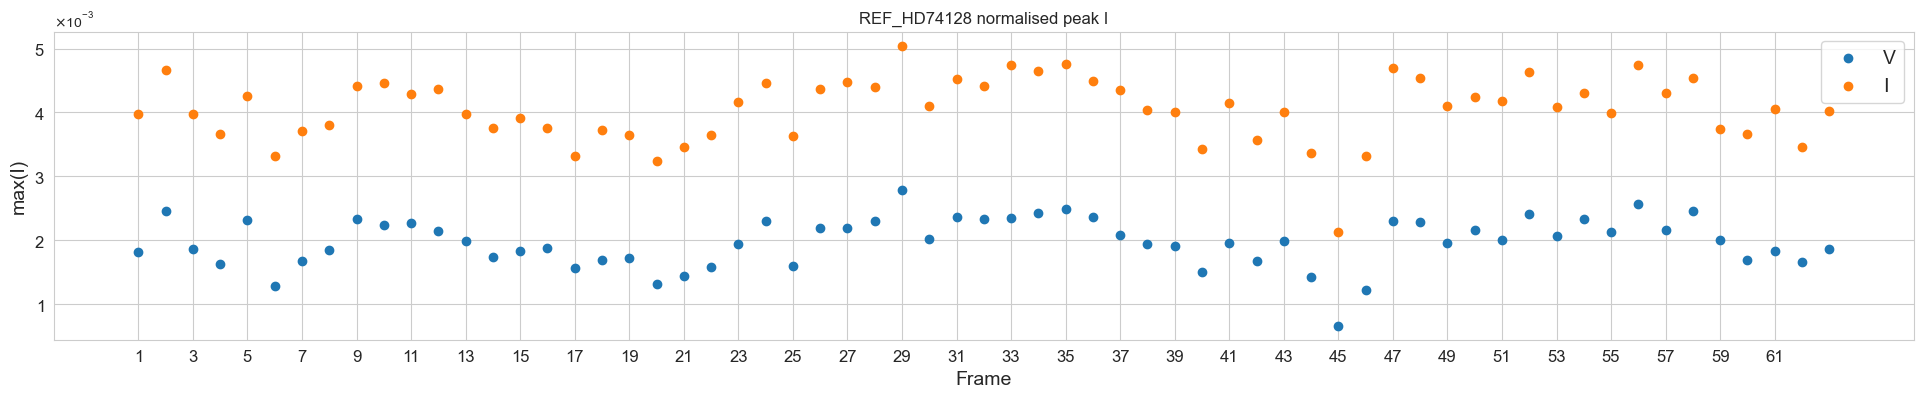

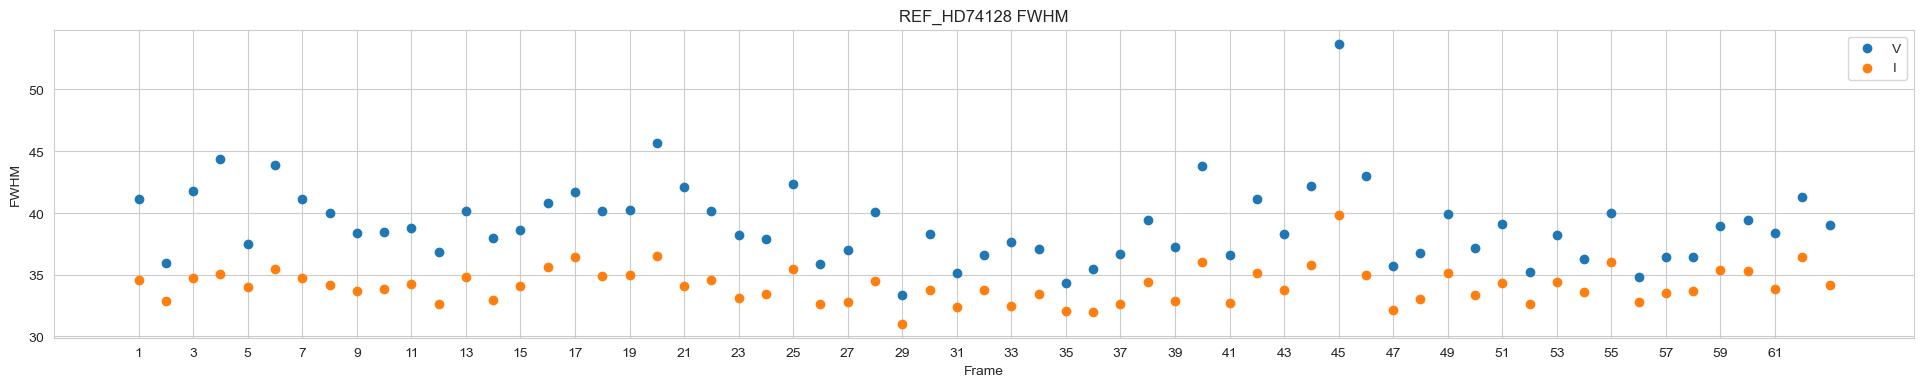

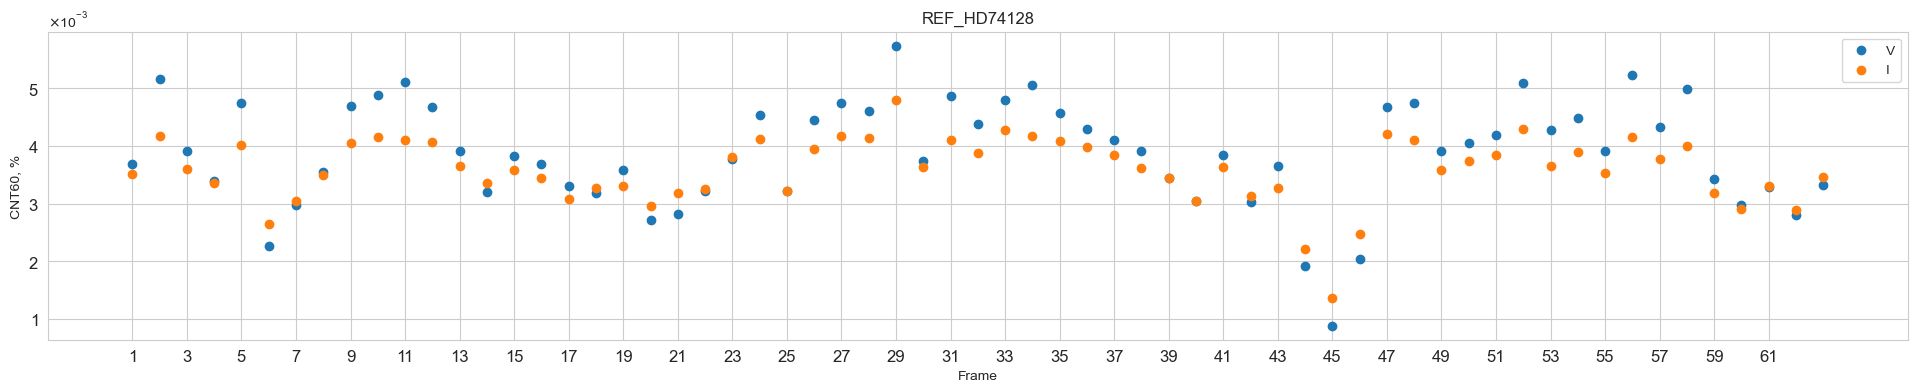

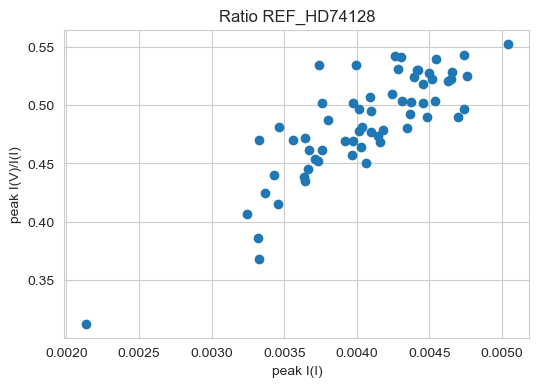

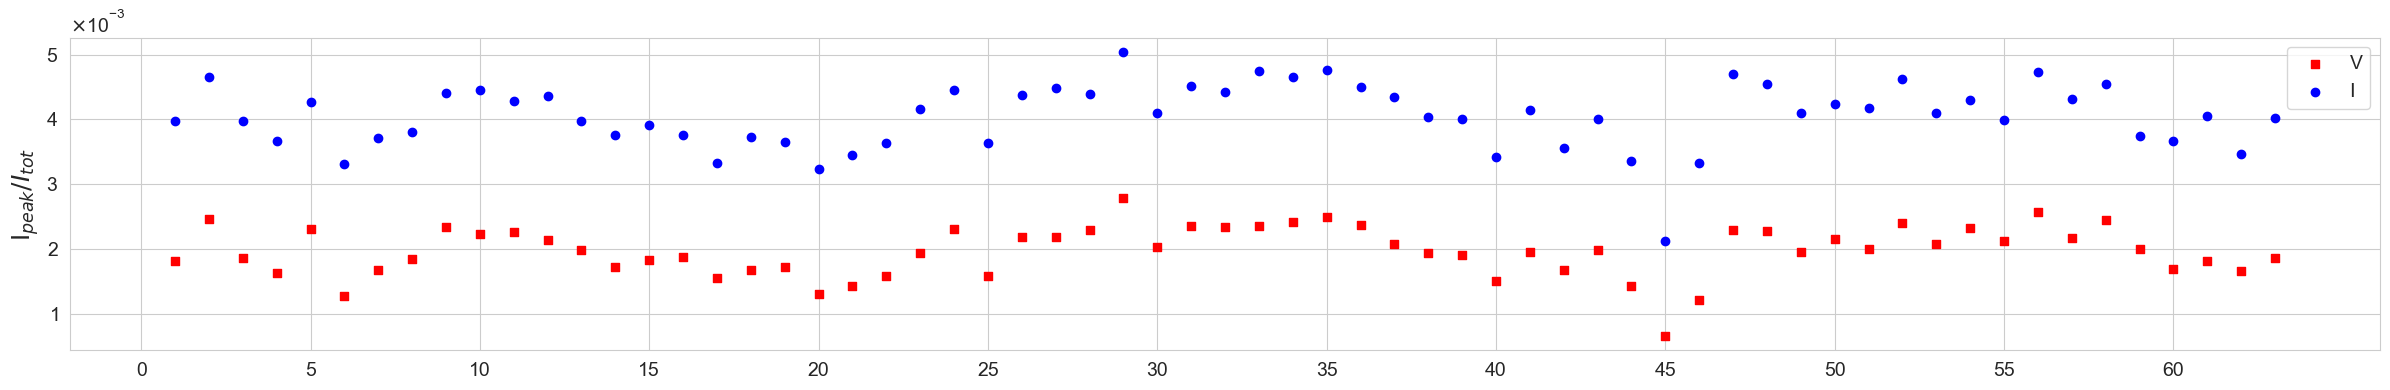

In [54]:
if DI == True:
    for star in stars:
        if star=='01.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
            input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
        elif star=='02.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
            input_filename =dirdat+'process_list.csv'
        else:
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/'+starnames[star]+'/'
            input_filename =dirdat+'process_list.csv'

        figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'

        specific_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'   #dirdat+'quality/'

        try:
        # Create target Directory
           os.mkdir(specific_folder)
        except FileExistsError:
            print("Directory " , specific_folder,  " already exists")

        output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
        df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
        output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
        df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)

        print(df_orig_v.head())

        plt.figure(figsize=(24, 4))
        plt.scatter(df_orig_v['frame'],df_orig_v['Peak_i(Strehl)'],label='V')
        plt.scatter(df_orig_i['frame'],df_orig_i['Peak_i(Strehl)'],label='I')
        plt.ylabel('max(I)', fontsize=14)
        plt.xlabel("Frame", fontsize=14)
        plt.title(star+' normalised peak I')
        plt.xticks(ticks=range(np.min(df_orig_v['frame']),np.max(df_orig_v['frame']),2),fontsize=12)
        plt.yticks(fontsize=12)
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.legend(fontsize=14)
        plt.savefig(specific_folder +star+'_peakI.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        plt.figure(figsize=(24, 4))
        plt.scatter(df_orig_v['frame'],df_orig_v['FWHM'],label='V')
        plt.scatter(df_orig_i['frame'],df_orig_i['FWHM'],label='I')
        plt.xticks(ticks=range(np.min(df_orig_v['frame']),np.max(df_orig_v['frame']),2))
        plt.ylabel('FWHM')
        plt.xlabel("Frame")
        plt.title(star+' FWHM')
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().yaxis.set_major_formatter(formatter)

        plt.legend()
        plt.savefig(specific_folder +star+'_fwhm.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        plt.figure(figsize=(24, 4))
        plt.scatter(df_orig_v['frame'],df_orig_v['CNT60[%]'],label='V')
        plt.scatter(df_orig_i['frame'],df_orig_i['CNT60[%]'],label='I')
        plt.ylabel('CNT60, %')
        plt.xlabel("Frame")
        plt.yticks(fontsize=12)
        plt.xticks(ticks=range(np.min(df_orig_v['frame']),np.max(df_orig_v['frame']),2), fontsize=12)
        plt.title(star)
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().yaxis.set_major_formatter(formatter)

        plt.legend()
        plt.savefig(specific_folder +star+'_cnt60.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()


        plt.figure(figsize=(6, 4))
        ratio={}
        ratio = df_orig_v['Peak_i(Strehl)']/df_orig_i['Peak_i(Strehl)']
        plt.scatter(df_orig_i['Peak_i(Strehl)'],ratio)
        plt.ylabel('peak I(V)/I(I)')
        plt.xlabel("peak I(I)")
        formatter = ScalarFormatter(useMathText=True)
        # formatter.set_powerlimits((-2, 2))
        # plt.gca().xaxis.set_major_formatter(formatter)
        plt.title('Ratio '+star)
        plt.savefig(specific_folder +star+'_peakRatio.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()


        #for paper
        plt.figure(figsize=(24, 4))

        # Subplot 1: Peak I
        plt.scatter(df_orig_v['frame'], df_orig_v['Peak_i(Strehl)'],marker='s', label='V',color='red')
        plt.scatter(df_orig_i['frame'], df_orig_i['Peak_i(Strehl)'], label='I',color='blue')
        plt.ylabel('I$_{peak}/I_{tot}$', fontsize=18)
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.gca().yaxis.offsetText.set_fontsize(14)
        plt.xticks(ticks=range(np.min(df_orig_v['frame'])-1, np.max(df_orig_v['frame'])+1, 5), fontsize=14)
        plt.tick_params(axis='both', labelbottom=True,length=5,width=1.5,labelsize=14)  # Remove labeled ticks on the x-axis
        plt.legend(fontsize=14)

        # Adjust x-axis limits to include the last tick
        #plt.xlim(np.min(df_orig_v['cycle'])-1, np.max(df_orig_v['cycle'])+1)
        plt.tight_layout()
        plt.savefig(specific_folder + star + '_for_paper.png', bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

In [55]:
ratio

0     0.457649
1     0.528738
2     0.468813
3     0.445502
4     0.542380
        ...   
58    0.534528
59    0.461464
60    0.450003
61    0.481149
62    0.464442
Name: Peak_i(Strehl), Length: 63, dtype: float64

## Variation of apperture polarimetry among frames
HERE IS NOT THE FINAL VERSION THAT WENT TO THE PAPER. FOR THE PAPER IN "Paper2_IRAS08_with_ref_correction.ipynb" FOR THE SELECTED FRAMES

In [56]:
star

'REF_HD74128'

In [57]:
#plotting aperture photometry
if PDI == True:
    for star in stars:
        if star=='AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
            input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
        elif star=='02.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
            input_filename =dirdat+'process_list.csv'
        else:
            dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+star+'/'
            input_filename =dirdat+'process_list.csv'

        figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'

        specific_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/variation_in_frames/'   #dirdat+'quality/'
        #specific_folder=dirdat+'quality/'
        try:
        # Create target Directory
           os.mkdir(specific_folder)
        except FileExistsError:
            print("Directory " , specific_folder,  " already exists")

        output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
        df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
        output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
        df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)

        output_filename = figfolder0+star+'_0-3_V_AP_per_cycle.txt'
        df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
        output_filename = figfolder0+star+'_0-3_I_AP_per_cycle.txt'
        df_0_3_i = pd.read_csv(output_filename, delim_whitespace=True)

        print(df_orig_v.columns.values)

        cycle_numbers = df_orig_v['cycle']
        current_labels = ['0-3', '0-5', '0-10', '0-50', '0-100', '1-3', '3-5', '3-30', '5-30']
        current_columnU = ['0-3_U/I[%]', '0-5_U/I[%]', '0-10_U/I[%]', '0-50_U/I[%]', '0-100_U/I[%]', '1-3_U/I[%]', '3-5_U/I[%]', '3-30_U/I[%]', '5-30_U/I[%]']
        current_columnQ = ['0-3_Q/I[%]', '0-5_Q/I[%]', '0-10_Q/I[%]', '0-50_Q/I[%]', '0-100_Q/I[%]', '1-3_Q/I[%]', '3-5_Q/I[%]', '3-30_Q/I[%]', '5-30_Q/I[%]']

        plt.figure(figsize=(12, 4))
        df_orig_i[current_columnU].plot(kind='box')
        positions = range(1, len(current_columnU) + 1)
        plt.xticks(positions, current_labels)
        plt.ylabel('U/I, %')
        plt.xlabel('annuli, pix')
        plt.title(star + ', I band')
        formatter = plt.ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().yaxis.set_major_formatter(formatter)
        ax = plt.subplot(111)
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.4))

        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.savefig(specific_folder + star + '_I_UI_annuli.png', bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        plt.figure(figsize=(12, 4))
        # Plot each current data with the corresponding label and cycle numbers in the legend
        df_orig_v[current_columnU].plot(kind='box')
        plt.xticks(positions, current_labels)
        plt.ylabel('U/I, %')
        plt.xlabel('annuli, pix')
        plt.title(star + ', V band')
        formatter = plt.ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().yaxis.set_major_formatter(formatter)
        ax = plt.subplot(111)
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.4))
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.savefig(specific_folder + star + '_V_UI_annuli.png', bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        plt.figure(figsize=(12, 4))
        # Plot each current data with the corresponding label and cycle numbers in the legend
        df_orig_i[current_columnQ].plot(kind='box')
        plt.xticks(positions, current_labels)
        plt.ylabel('Q/I, %')
        plt.xlabel('annuli, pix')
        plt.title(star + ', I band')
        formatter = plt.ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.savefig(specific_folder + star + '_I_QI_annuli.png', bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        plt.figure(figsize=(12, 4))
        # Plot each current data with the corresponding label and cycle numbers in the legend
        df_orig_v[current_columnQ].plot(kind='box')
        plt.xticks(positions, current_labels)
        plt.xlabel('annuli, pix')
        plt.ylabel('Q/I, %')
        plt.title(star + ', V band')
        formatter = plt.ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.savefig(specific_folder + star + '_V_QI_annuli.png', bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

## Quality values for the data

In [58]:
if PDI == True:
    for star in stars:


        figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'

        specific_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
        # Create target Directory
        try:
            os.mkdir(specific_folder)
        except FileExistsError:
            print("Directory " , specific_folder,  " already exists")

        output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
        df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
        output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
        df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)

        #output_filename = dirdat+star+'_0-3_V_AP_per_cycle.txt'
        #df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
        #output_filename = dirdat+star+'_0-3_I_AP_per_cycle.txt'
        #df_0_3_i = pd.read_csv(output_filename, delim_whitespace=True)

        #print(df_orig_v.head())
        print(star)
        print('V')
        print('median peak I normalised to total %.6f percents +- %.6f'%(np.median(df_orig_v['Peak_i(Strehl)']*100),np.std(df_orig_v['Peak_i(Strehl)']*100)))
        print('median CNT60 normalised to total %.6f percents +- %.6f'%(np.median(df_orig_v['CNT60[%]']),np.std(df_orig_v['CNT60[%]'])))

        print('median peak PI normalised to total I %.6f percents +- %.6f'%(np.median(df_orig_v['Peak_PI']*100),np.std(df_orig_v['Peak_PI']*100)))

        print('median FWHM %.3f mas +- %.3f'%(np.median(df_orig_v['FWHM']),np.std(df_orig_v['FWHM'])))
        print('ratio of FWHM %.3f  '%(np.max(df_orig_v['FWHM'])/np.min(df_orig_v['FWHM'])))

        print('I')
        print('median peak I normalised to total %.6f percents +- %.6f'%(np.median(df_orig_i['Peak_i(Strehl)']*100),np.std(df_orig_i['Peak_i(Strehl)']*100)))
        print('median CNT60 normalised to total %.6f percents +- %.6f'%(np.median(df_orig_i['CNT60[%]']),np.std(df_orig_i['CNT60[%]'])))

        print('median peak PI normalised to total I %.6f percents +- %.6f'%(np.median(df_orig_i['Peak_PI']*100),np.std(df_orig_i['Peak_PI']*100)))

        print('median FWHM %.3f mas +- %.3f'%(np.median(df_orig_i['FWHM']),np.std(df_orig_i['FWHM'])))
        print('ratio of FWHM %.3f  '%(np.max(df_orig_i['FWHM'])/np.min(df_orig_i['FWHM'])))

In [59]:
if DI == True:
    for star in stars:

        figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'

        specific_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
        # Create target Directory
        try:
            os.mkdir(specific_folder)
        except FileExistsError:
            print("Directory " , specific_folder,  " already exists")

        output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
        df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
        output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
        df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)

        #output_filename = dirdat+star+'_0-3_V_AP_per_cycle.txt'
        #df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
        #output_filename = dirdat+star+'_0-3_I_AP_per_cycle.txt'
        #df_0_3_i = pd.read_csv(output_filename, delim_whitespace=True)

        #print(df_orig_v.head())
        print(star)
        print('V')
        print('median peak I normalised to total %.6f percents +- %.6f'%(np.median(df_orig_v['Peak_i(Strehl)']*100),np.std(df_orig_v['Peak_i(Strehl)']*100)))
        print('median CNT60 normalised to total %.6f percents +- %.6f'%(np.median(df_orig_v['CNT60[%]']),np.std(df_orig_v['CNT60[%]'])))


        print('median FWHM %.3f mas +- %.3f'%(np.median(df_orig_v['FWHM']),np.std(df_orig_v['FWHM'])))
        print('ratio of FWHM %.3f  '%(np.max(df_orig_v['FWHM'])/np.min(df_orig_v['FWHM'])))

        print('I')
        print('median peak I normalised to total %.6f percents +- %.6f'%(np.median(df_orig_i['Peak_i(Strehl)']*100),np.std(df_orig_i['Peak_i(Strehl)']*100)))
        print('median CNT60 normalised to total %.6f percents +- %.6f'%(np.median(df_orig_i['CNT60[%]']),np.std(df_orig_i['CNT60[%]'])))

        print('median FWHM %.3f mas +- %.3f'%(np.median(df_orig_i['FWHM']),np.std(df_orig_i['FWHM'])))
        print('ratio of FWHM %.3f  '%(np.max(df_orig_i['FWHM'])/np.min(df_orig_i['FWHM'])))



Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/REF_HD74128/Quality_indiv_cycles/  already exists
REF_HD74128
V
median peak I normalised to total 0.199475 percents +- 0.038179
median CNT60 normalised to total 0.003910 percents +- 0.000907
median FWHM 38.474 mas +- 3.199
ratio of FWHM 1.610  
I
median peak I normalised to total 0.409299 percents +- 0.049476
median CNT60 normalised to total 0.003630 percents +- 0.000565
median FWHM 34.063 mas +- 1.420
ratio of FWHM 1.284  


/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_38452/1054895668.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_38452/1054895668.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)


In [60]:
#stars=['IRAS08544-4431', 'IRAS08544-4431_dc_notnorm','AR_Pup','AR_Pup_dc_notnorm']
#stars=['HR4049_20190108','HR4049_20190107','HD71253','HD94680','HD96314','HD98025','V709_Car','HR4226','UMon_Katya']
# stars=['02.SCI_AR_Pup']
stars=['REF_HD74128']

for star in stars:

    figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
    
    specific_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
    # Create target Directory
    try:
        os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
        
    output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
  
    #print(df_orig_v.columns)
    print(df_orig_v.FWHM)
    

Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/REF_HD74128/Quality_indiv_cycles/  already exists
0     41.157
1     35.912
2     41.738
3     44.401
4     37.447
       ...  
58    38.957
59    39.446
60    38.401
61    41.298
62    39.054
Name: FWHM, Length: 63, dtype: float64


/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_38452/3639236390.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_38452/3639236390.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)


## Number of counts per frame

In [49]:
if PDI == True:
    for star in stars:
        #figfolder=dirdat+'original/'


        if star =='01.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
            input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
        elif star=='02.SCI_AR_Pup':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
            input_filename =dirdat+'process_list.csv'
        else:
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/'+starnames[star]+'/'
            input_filename =dirdat+'process_list.csv'


        table = pd.read_csv(input_filename)
        table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

        processes=table['id']

        reference={process:ref for process,ref in zip(table['id'], table['reference'])}


        #print(reference)
        print(star)
        for fittype in fittypes:
            #output_filename = dirdat+star+'_'+band[int(fittype)-1]+'_Original_AP_per_cycle.txt'
            print(band[int(fittype)-1])
            for process in processes:
                if star=='UMon':
                    dirName=dirdat
                    iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar_umon(dirName,process,fittype)
                else:
                    dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
                    iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)

                n=q.shape[0]

                iq_sum=np.sum(iq)
                iu_sum=np.sum(iu)
                pi_sum=np.sum(pi)
                print('sum of IQ %.2e, IU %.2e, PI %.2e' % (iq_sum, iu_sum, pi_sum))


In [50]:
df_orig_i

,reference,frame,FWHM,CNT60[%],Peak_i(Strehl),0-3_PSF,0-5_PSF,0-10_PSF,0-50_PSF,0-100_PSF,1-3_PSF,3-5_PSF,3-30_PSF,5-30_PSF
0,frame01_combined.fits,1,34.549,0.00351,0.003969,79578.108,174930.220,355539.444,662355.467,812603.052,75847.805908,95352.111328,491917.828827,396565.717499
1,frame02_combined.fits,2,32.879,0.00418,0.004658,95681.006,208289.283,401540.572,699174.030,841326.322,91268.757812,112608.276855,515127.889008,402519.612152
2,frame03_combined.fits,3,34.738,0.00360,0.003975,81418.870,179862.099,368611.743,681928.258,829722.658,77638.082520,98443.229492,510254.457300,411811.227808
3,frame04_combined.fits,4,35.059,0.00336,0.003662,76448.939,169406.792,352003.734,671064.497,823349.878,72939.799561,92957.853271,499653.445397,406695.592126
4,frame05_combined.fits,5,34.017,0.00401,0.004263,90052.341,199220.981,395531.495,694225.092,833888.322,85919.252441,109168.639648,518067.414362,408898.774714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,frame59_combined.fits,59,35.376,0.00319,0.003741,76782.098,172114.851,358627.733,638433.160,778369.255,73328.273193,95332.752930,480842.293490,385509.540561
59,frame60_combined.fits,60,35.294,0.00290,0.003670,71614.654,159959.791,331369.293,608111.412,752033.995,68349.437012,88345.136719,453015.101950,364669.965231
60,frame61_combined.fits,61,33.850,0.00331,0.004061,78077.333,171440.023,341461.750,625644.583,769695.790,74413.539795,93362.689209,461635.766907,368273.077698
61,frame62_combined.fits,62,36.440,0.00288,0.003463,69882.704,157682.760,331536.156,625587.712,777003.128,66722.617432,87800.056396,465204.521405,377404.465009
